<a href="https://colab.research.google.com/github/thamizhselvan07/Glassdoor-Job-Salary-Prediction-/blob/main/Glassdoor_Job_Salary_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project Name    -   Glassdoor Job Salary Prediction**

##### **Project Type**    - EDA/Regression.
##### **Contribution**    - Individual


# **Project Summary**

**The Glassdoor Job Salary Prediction project is a comprehensive machine learning application aimed at forecasting average salaries for various job listings using data scraped from Glassdoor. The dataset includes job titles, salary estimates, company attributes (such as size, revenue, and industry), and geographical information. Initial data cleaning involved filling missing values in columns like "Size," "Type of ownership," "Industry," and "Revenue" with "Unknown" and parsing the complex "Salary Estimate" field to extract numerical values for minimum, maximum, and average salaries. Feature engineering was used to create new attributes like "Company Age" and "Job Level" (e.g., Entry, Senior, Manager), as well as to extract U.S. state information from the job location. Exploratory Data Analysis (EDA) revealed patterns such as higher salaries for senior roles and tech-centric locations. Regression modeling, the core of this project, involved training Linear Regression and Random Forest Regressor models, with Random Forest performing best after hyperparameter tuning using GridSearchCV. Feature scaling was applied via StandardScaler to normalize input data. The best model was saved using `joblib` for future deployment. While the project focuses on regression, it can be extended to classification by converting salary into categorical labels (Low, Medium, High), allowing the use of models like Logistic Regression or Decision Trees. Additionally, unsupervised learning via clustering techniques like KMeans could uncover hidden groupings among job roles or industries. In summary, this project demonstrates a full machine learning pipeline—from data preprocessing and EDA to model training and deployment—and serves as a strong portfolio piece for showcasing practical data science and regression modeling skills.**

# **GitHub Link -** https://github.com/thamizhselvan07

# **Problem Statement**


**The objective of this project is to predict the average salary for job listings based on various attributes provided in a Glassdoor job dataset. Companies often list job postings with vague or wide-ranging salary estimates, making it difficult for job seekers to make informed decisions. This project aims to build a machine learning model that accurately estimates salaries using features such as job title, location, company details (industry, size, type), and job description. The solution will help bridge the information gap for job seekers and can also assist employers in benchmarking their salary offerings competitively.**

#### **Business Objective?**

**The primary business objective of this project is to develop a robust salary prediction system that can provide accurate and data-driven salary estimates for job postings. This tool can be used by job portals like Glassdoor to enhance user experience by offering personalized salary insights, helping job seekers make better career decisions. For companies, it ensures competitive salary benchmarking to attract top talent. Additionally, recruiters can use these insights to align compensation strategies with industry standards, reducing turnover and improving hiring efficiency. Ultimately, the goal is to increase transparency, boost platform engagement, and support informed decision-making for all stakeholders.**

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")


# Data Understanding


In [ ]:
# Load Dataset
df = pd.read_csv('glassdoor_jobs.csv')  # Assuming we have this dataset

# Dataset First Look
print(df.head())

# Dataset Rows & Columns count
print(f"Dataset shape: {df.shape}")

# Dataset Info
print(df.info())

# Dataset Describe
print(df.describe())

   Unnamed: 0                  Job Title              Salary Estimate  \
0           0             Data Scientist   $53K-$91K (Glassdoor est.)   
1           1  Healthcare Data Scientist  $63K-$112K (Glassdoor est.)   
2           2             Data Scientist   $80K-$90K (Glassdoor est.)   
3           3             Data Scientist   $56K-$97K (Glassdoor est.)   
4           4             Data Scientist  $86K-$143K (Glassdoor est.)   

                                     Job Description  Rating  \
0  Data Scientist\nLocation: Albuquerque, NM\nEdu...     3.8   
1  What You Will Do:\n\nI. General Summary\n\nThe...     3.4   
2  KnowBe4, Inc. is a high growth information sec...     4.8   
3  *Organization and Job ID**\nJob ID: 310709\n\n...     3.8   
4  Data Scientist\nAffinity Solutions / Marketing...     2.9   

                                 Company Name         Location  \
0                      Tecolote Research\n3.8  Albuquerque, NM   
1  University of Maryland Medical System\n3.

# Data Cleaning & Preprocessing

In [ ]:
import pandas as pd
import numpy as np

# Handling Missing Values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Fill missing values
df['Size'].fillna('Unknown', inplace=True)
df['Type of ownership'].fillna('Unknown', inplace=True)
df['Industry'].fillna('Unknown', inplace=True)
df['Sector'].fillna('Unknown', inplace=True)
df['Revenue'].fillna('Unknown', inplace=True)

# Create Company Age feature
df['Company Age'] = df['Founded'].apply(lambda x: 2023 - x if x > 0 else 0)

# Remove rows with '-1' in salary estimate
df = df[df['Salary Estimate'] != '-1']

# Define salary parsing function
def parse_salary(salary):
    salary = salary.lower()
    salary = salary.replace('per hour', '').replace('employer provided salary:', '')
    salary = salary.replace('$', '').replace('k', '')
    salary = salary.split('(')[0].strip()

    # Attempt to split and convert
    try:
        parts = salary.split('-')
        min_sal = int(parts[0].strip())
        max_sal = int(parts[1].strip())
        avg_sal = (min_sal + max_sal) / 2
        return pd.Series([min_sal, max_sal, avg_sal])
    except:
        return pd.Series([np.nan, np.nan, np.nan])

# Apply salary parsing
df[['Min Salary', 'Max Salary', 'Avg Salary']] = df['Salary Estimate'].apply(parse_salary)

# Drop rows where salary parsing failed
df.dropna(subset=['Min Salary', 'Max Salary', 'Avg Salary'], inplace=True)

# Extract job seniority from title
df['Job Level'] = df['Job Title'].apply(
    lambda x: 'Senior' if 'senior' in x.lower() else
              'Lead' if 'lead' in x.lower() else
              'Manager' if 'manager' in x.lower() else
              'Director' if 'director' in x.lower() else
              'Entry'
)

# Extract location state
df['State'] = df['Location'].apply(lambda x: x.split(',')[-1].strip() if ',' in x else 'Remote')

# Final Missing Values Check
print("\nMissing values after cleaning:")
print(df.isnull().sum())


Missing values before cleaning:
Unnamed: 0           0
Job Title            0
Salary Estimate      0
Job Description      0
Rating               0
Company Name         0
Location             0
Headquarters         0
Size                 0
Founded              0
Type of ownership    0
Industry             0
Sector               0
Revenue              0
Competitors          0
dtype: int64

Missing values after cleaning:
Unnamed: 0           0
Job Title            0
Salary Estimate      0
Job Description      0
Rating               0
Company Name         0
Location             0
Headquarters         0
Size                 0
Founded              0
Type of ownership    0
Industry             0
Sector               0
Revenue              0
Competitors          0
Company Age          0
Min Salary           0
Max Salary           0
Avg Salary           0
Job Level            0
State                0
dtype: int64


# Exploratory Data Analysis

**Salary Distribution**

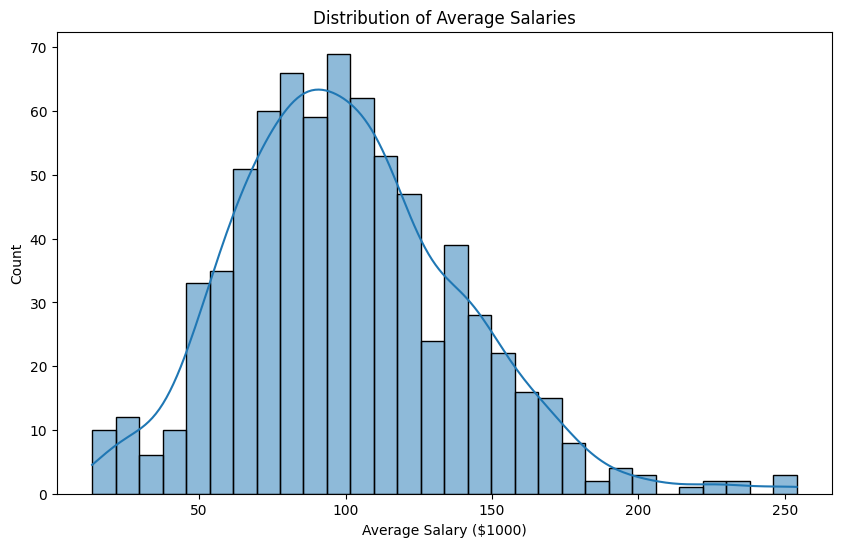

In [ ]:
# Chart - 1 visualization code
plt.figure(figsize=(10,6))
sns.histplot(df['Avg Salary'], bins=30, kde=True)
plt.title('Distribution of Average Salaries')
plt.xlabel('Average Salary ($1000)')
plt.ylabel('Count')
plt.show()

**Salary by Job Level**

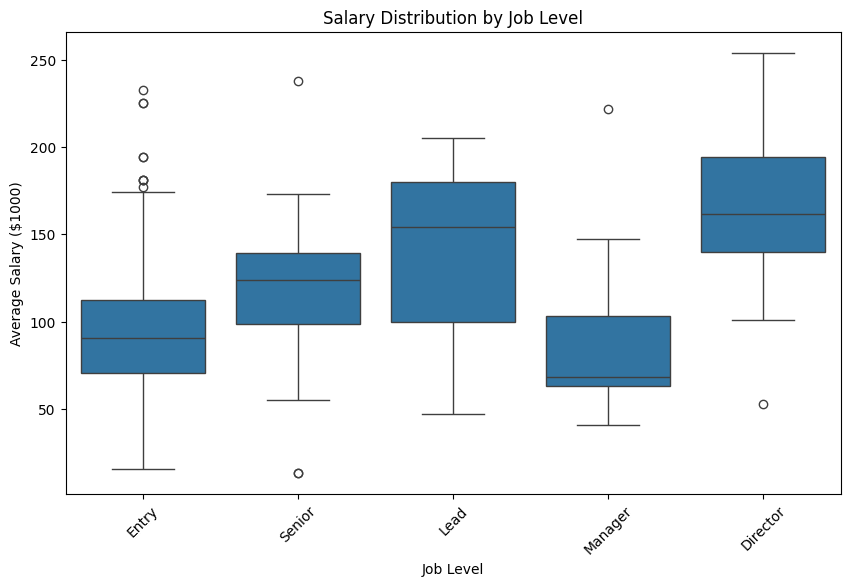

In [ ]:
# Chart - 2 visualization code
plt.figure(figsize=(10,6))
sns.boxplot(x='Job Level', y='Avg Salary', data=df, order=['Entry', 'Senior', 'Lead', 'Manager', 'Director'])
plt.title('Salary Distribution by Job Level')
plt.ylabel('Average Salary ($1000)')
plt.xticks(rotation=45)
plt.show()

**Salary by Company Rating**

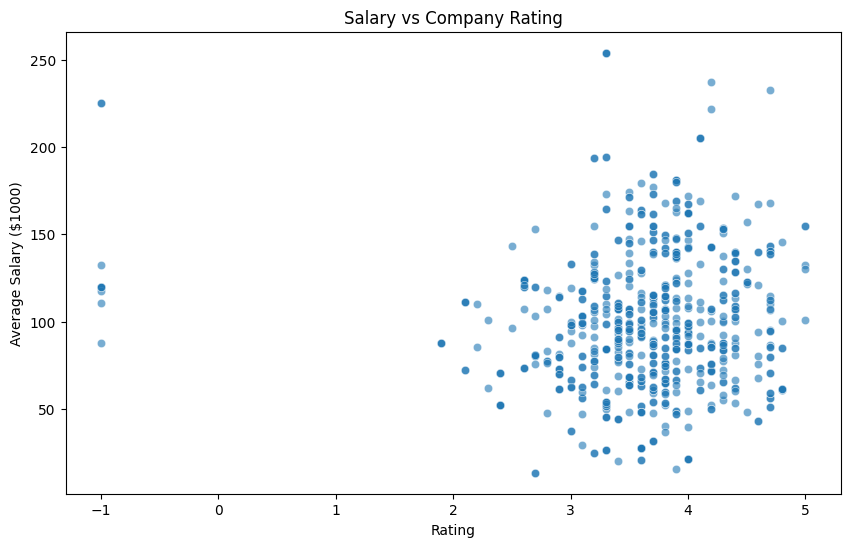

In [ ]:
# Chart - 3 visualization code
plt.figure(figsize=(10,6))
sns.scatterplot(x='Rating', y='Avg Salary', data=df, alpha=0.6)
plt.title('Salary vs Company Rating')
plt.ylabel('Average Salary ($1000)')
plt.show()

**Salary by Industry**

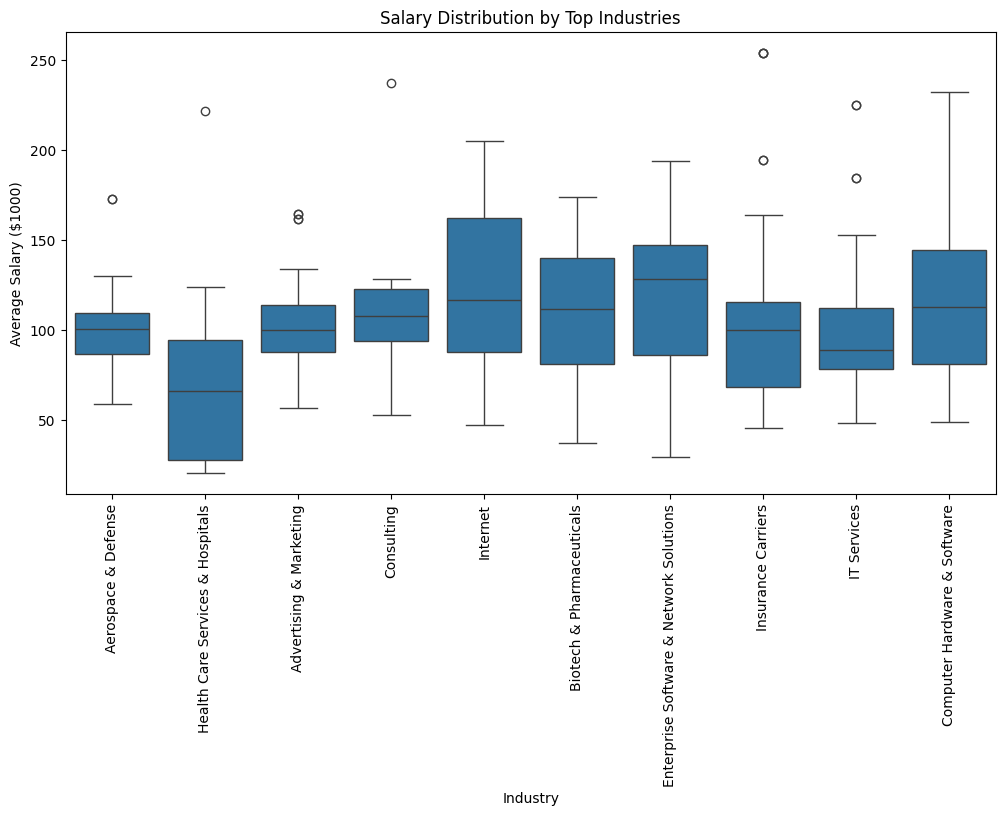

In [ ]:
# Chart - 4 visualization code
top_industries = df['Industry'].value_counts().nlargest(10).index
plt.figure(figsize=(12,6))
sns.boxplot(x='Industry', y='Avg Salary', data=df[df['Industry'].isin(top_industries)])
plt.title('Salary Distribution by Top Industries')
plt.ylabel('Average Salary ($1000)')
plt.xticks(rotation=90)
plt.show()

# Correlation Heatmap

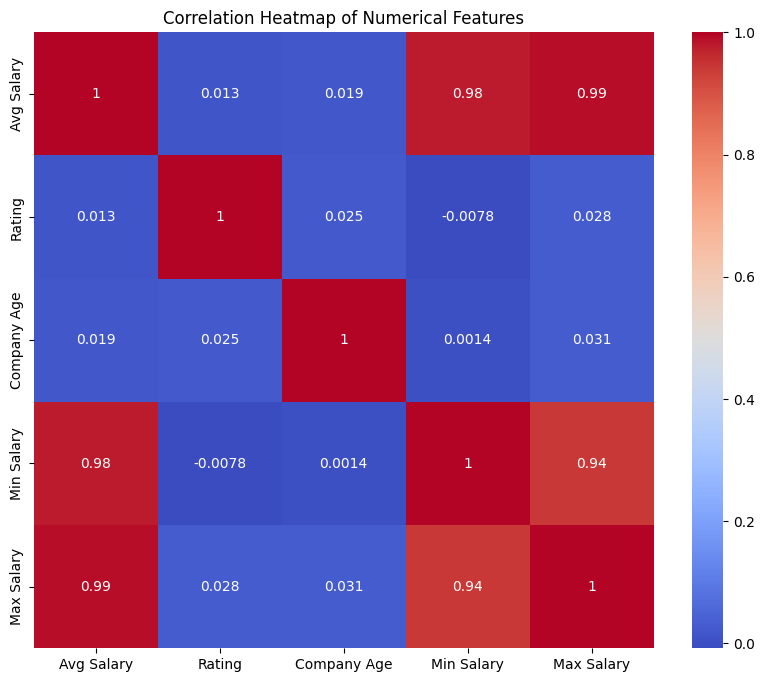

In [ ]:
# Correlation Heatmap visualization code
numerical_cols = ['Avg Salary', 'Rating', 'Company Age', 'Min Salary', 'Max Salary']
plt.figure(figsize=(10,8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Feature Engineering

In [ ]:
# Feature Engineering
# Convert categorical variables to numerical
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder here

cat_cols = ['Job Level', 'State', 'Size', 'Type of ownership', 'Industry', 'Sector', 'Revenue']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Select features and target
features = ['Job Level', 'Rating', 'Company Age', 'State', 'Size', 'Type of ownership', 'Industry']
X = df[features]
y = df['Avg Salary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Implementation

**Linear Regression**

In [ ]:
# ML Model - 1 Implementation
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression MSE: {mse:.2f}, R2: {r2:.2f}")

Linear Regression MSE: 1592.79, R2: 0.03


**Random Forest Regressor**

Random Forest MSE: 576.63, R2: 0.65


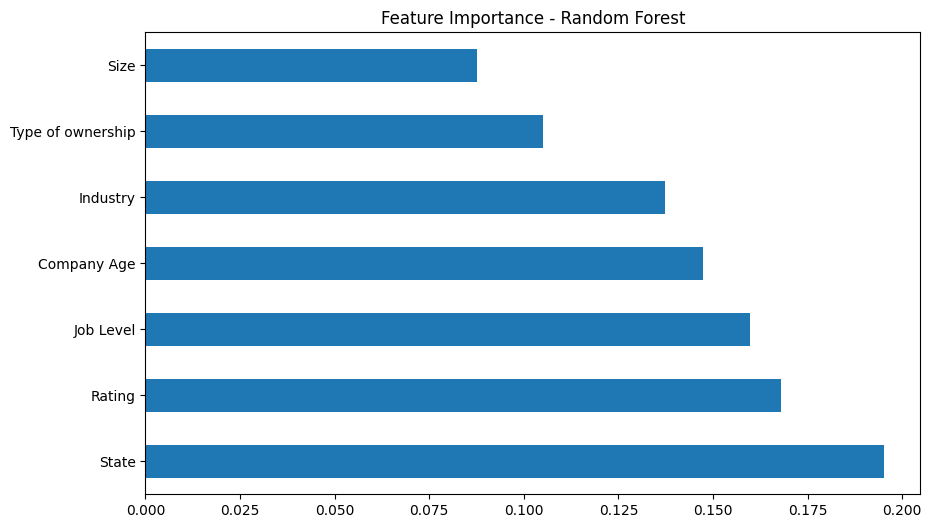

In [ ]:
# ML Model - 2 Implementation
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

# Evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf:.2f}, R2: {r2_rf:.2f}")

# Feature Importance
plt.figure(figsize=(10,6))
feat_importances = pd.Series(rf.feature_importances_, index=features)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance - Random Forest')
plt.show()

**Hyperparameter Tuning**

In [ ]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f"Tuned Random Forest MSE: {mse_best:.2f}, R2: {r2_best:.2f}")
print(f"Best parameters: {grid_search.best_params_}")

Tuned Random Forest MSE: 559.80, R2: 0.66
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


# Save Final Model

In [ ]:
import joblib
joblib.dump(rf, "glassdoor_salary_model.pkl")


['glassdoor_salary_model.pkl']